In [22]:
import numpy as np
import pandas as pd
import gzip
import json

from pprint import pprint

In [23]:
#@title Turkish StopWords

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


In [24]:
import json

train_data_path = "training-dataset.jsonl.gz"

posts_train = dict()
profiles = dict()

with gzip.open(train_data_path, "rt") as fh:
  for line in fh:
    sample = json.loads(line)
    profile = sample["profile"]
    username = profile["username"]
    posts_train[username] = sample["posts"]
    profiles[username] = profile



In [25]:
import re

def preprocess_text(text: str):
    # lower casing Turkish Text, Don't use str.lower :)
    text = text.casefold()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and punctuation
    # HERE THE EMOJIS stuff are being removed, you may want to keep them :D
    text = re.sub(r'[^a-zçğıöşü0-9\s#@]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [26]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

def get_avg_like_count(username):
    def calculate_avg(posts: list):
        total = 0
        count = 0
        for post in posts:
            like_count = post.get("like_count", 0)
            if like_count is None:
                like_count = 0
            total += like_count
            count += 1

        return total / count if count > 0 else 0

    # Check if the username exists in training or testing data
    if username in posts_train:
        return calculate_avg(posts_train[username])
    else:
        print(f"No data available for {username}")
        return -1

# Initialize an empty list to store rows
data = []
post_corpus = []
# Loop through usernames in the training set
for username, posts in posts_train.items():
    # Get profile info for the user
    profile = profiles[username]

    average_like = get_avg_like_count(username)
    # Extract profile-related features
    profile_info = {
        #"username": username,
        "follower_count": profile.get("follower_count", 0) or 0,
        "following_count": profile.get("following_count", 0) or 0,
        "highlight_reel_count": profile.get("highlight_reel_count", 0) or 0,
        "post_count": profile.get("post_count", 0) or 0,
        "is_verified": profile.get("is_verified", False),
        "is_business_account": profile.get("is_business_account", False),
        "is_private": profile.get("is_private", False),
        "category_name": profile.get("category_name", "Unknown"),
        "average_like": average_like,
        "username": profile.get("username", "Unknown")
    }
    
    # Loop through posts and extract post-related features
    for post in posts:
        post_info = {
            "media_type": post.get("media_type", 0),
            "comments_count": post.get("comments_count", 0) or 0,
            "like_count": post.get("like_count", 0) or 0,
            "caption": post.get("caption", ""),
            "timestamp": post.get("timestamp", ""),
        }
        post_caption = post.get("caption", "")  # Get caption or empty string
        if post_caption:  # If caption exists, preprocess it
            post_caption = preprocess_text(post_caption)
        else:
            post_caption = ""  # Keep empty string for missing captions

        # Add the processed (or empty) caption to the corpus
        post_corpus.append(post_caption)
            
        
        # Combine profile and post info
        combined_info = {**profile_info, **post_info}
        data.append(combined_info)

# Convert the list of dictionaries into a DataFrame
df_train = pd.DataFrame(data)

# label encoder
label_encoder = LabelEncoder()
df_train["category_name"] = label_encoder.fit_transform(df_train['category_name'])
df_train["media_type"] = label_encoder.fit_transform(df_train['media_type'])

# Fit and transform the TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words=turkish_stopwords, max_features=500)
x_post_tfidf = vectorizer.fit_transform(post_corpus)
tfidf_df = pd.DataFrame(x_post_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
print(f"TF-IDF matrix shape: {x_post_tfidf.shape}")

# Convert binary columns (True/False) to 0/1
binary_columns = ['is_verified', 'is_private', 'is_business_account']
for col in binary_columns:
    df_train[col] = df_train[col].astype(int)

# Define the profile-related columns to be removed
profile_related_columns = [
    "follower_count", 
    "following_count", 
    "highlight_reel_count", 
    "post_count", 
    "is_verified", 
    "is_business_account", 
    "is_private", 
    "category_name", 
    "average_like", 
    "username", 
]

#df_train = df_train.drop(columns=profile_related_columns, errors="ignore")
# Convert timestamp to Unix timestamp (numerical value)
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])  # Ensure it's a datetime object
# Extract features from timestamp
df_train['hour'] = df_train['timestamp'].dt.hour
df_train['day_of_week'] = df_train['timestamp'].dt.dayofweek
df_train['day_of_year'] = df_train['timestamp'].dt.dayofyear
df_train['month'] = df_train['timestamp'].dt.month
# Example: Bin hours into time of day
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']
df_train['time_of_day'] = pd.cut(df_train['hour'], bins=bins, labels=labels, right=False)
# Convert categorical 'time_of_day' to numerical using one-hot encoding if needed
df_train = pd.get_dummies(df_train, columns=['time_of_day'])
# Encode hour as sine and cosine
#df_train['hour_sin'] = np.sin(2 * np.pi * df_train['hour'] / 24)
#df_train['hour_cos'] = np.cos(2 * np.pi * df_train['hour'] / 24)
## Encode day of the week as sine and cosine
#df_train['day_of_week_sin'] = np.sin(2 * np.pi * df_train['day_of_week'] / 7)
#df_train['day_of_week_cos'] = np.cos(2 * np.pi * df_train['day_of_week'] / 7)
## Transform into sine and cosine
#df_train['month_sin'] = np.sin(2 * np.pi * df_train['month'] / 12)
#df_train['month_cos'] = np.cos(2 * np.pi * df_train['month'] / 12)

#df_train = df_train.drop(columns=['hour', 'day_of_week', 'month', 'timestamp'])

# Convert Boolean columns to numerical (1/0)
df_train[['time_of_day_Night', 'time_of_day_Morning', 'time_of_day_Afternoon', 'time_of_day_Evening']] = \
    df_train[['time_of_day_Night', 'time_of_day_Morning', 'time_of_day_Afternoon', 'time_of_day_Evening']].astype(int)



df_train = df_train.drop(columns=['caption', 'timestamp', 'hour', 'month', 'post_count'])
# Display the DataFrame
print(f"df_train matrix shape: {df_train.head()}")

df_combined = pd.concat([df_train.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

df_combined.head(100)

TF-IDF matrix shape: (187302, 500)
df_train matrix shape:    follower_count  following_count  highlight_reel_count  is_verified  \
0            1167              192                     6            0   
1            1167              192                     6            0   
2            1167              192                     6            0   
3            1167              192                     6            0   
4            1167              192                     6            0   

   is_business_account  is_private  category_name  average_like    username  \
0                    1           0            230     11.542857  deparmedya   
1                    1           0            230     11.542857  deparmedya   
2                    1           0            230     11.542857  deparmedya   
3                    1           0            230     11.542857  deparmedya   
4                    1           0            230     11.542857  deparmedya   

   media_type  comments_coun

,follower_count,following_count,highlight_reel_count,is_verified,is_business_account,is_private,category_name,average_like,username,media_type,...,ürünleri,üst,üzere,üzerinde,üzerinden,üzerine,şeker,şekilde,şimdi,şık
0,1167,192,6,0,1,0,230,11.542857,deparmedya,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1167,192,6,0,1,0,230,11.542857,deparmedya,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1167,192,6,0,1,0,230,11.542857,deparmedya,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1167,192,6,0,1,0,230,11.542857,deparmedya,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1167,192,6,0,1,0,230,11.542857,deparmedya,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,11997,17,15,0,1,0,53,31.514286,kafesfirin,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,11997,17,15,0,1,0,53,31.514286,kafesfirin,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,11997,17,15,0,1,0,53,31.514286,kafesfirin,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,11997,17,15,0,1,0,53,31.514286,kafesfirin,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
print(df_train.isnull().sum())

follower_count           0
following_count          0
highlight_reel_count     0
is_verified              0
is_business_account      0
is_private               0
category_name            0
average_like             0
username                 0
media_type               0
comments_count           0
like_count               0
day_of_week              0
day_of_year              0
time_of_day_Night        0
time_of_day_Morning      0
time_of_day_Afternoon    0
time_of_day_Evening      0
dtype: int64


In [13]:
print(df_test_prepared.isnull().sum())

follower_count          0
following_count         0
highlight_reel_count    0
is_verified             0
is_business_account     0
is_private              0
category_name           0
average_like            0
media_type              0
comments_count          0
engagement_rate         0
dtype: int64


In [16]:
df_test_prepared.head()

,follower_count,following_count,highlight_reel_count,is_verified,is_business_account,is_private,category_name,media_type,comments_count,average_like,engagement_rate
0,8850,300,43,0,0,0,213,0,2,158.314286,0.017889
1,65149,1,14,0,1,0,123,2,0,99.828571,0.001532
2,289856,39,51,0,0,0,331,2,75,1224.142857,0.004223
3,172,4,3,0,1,0,264,1,1,5.200000,0.030233
4,1538,164,8,0,1,0,43,1,0,15.400000,0.010013


In [28]:
def log_mse_like_counts(y_true, y_pred):
  """
  Calculate the Log Mean Squared Error (Log MSE) for like counts (log(like_count + 1)).

  Parameters:
  - y_true: array-like, actual like counts
  - y_pred: array-like, predicted like counts

  Returns:
  - log_mse: float, Log Mean Squared Error
  """
  # Ensure inputs are numpy arrays
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  # Log transformation: log(like_count + 1)
  log_y_true = np.log1p(y_true)
  log_y_pred = np.log1p(y_pred)

  # Compute squared errors
  squared_errors = (log_y_true - log_y_pred) ** 2

  # Return the mean of squared errors
  return np.mean(squared_errors)

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

# Assuming df_train is already defined
scaler = StandardScaler()
# Scale the data
X = df_train.drop(columns=['username', 'like_count'])
y = df_train['like_count']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation data using the same scaler
X_val_scaled = scaler.transform(X_val)


# Transform target variable for training
y_train_log = np.log1p(y_train)

# Train the model
model = RandomForestRegressor(
    n_estimators=100,  # Reduce the number of trees
    max_depth=15,     # Limit tree depth
    min_samples_split=10,  # Require more samples to split
    random_state=42,
)

model.fit(X_train_scaled, y_train_log)

# Predict on validation set
y_pred_log = model.predict(X_val_scaled)

# Inverse transform predictions to original scale
y_pred = np.expm1(y_pred_log)

# Calculate Log MSE
log_mse = log_mse_like_counts(y_val, y_pred)
print(f"Log MSE: {log_mse}")



Log MSE: 0.48410362714173644


## The model that we've used for round 1 and 2. Only difference is that I used all training set to train the model for the second round.

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


# Separate features (X) and target variable (y)
X = df_train.drop(columns=['like_count', 'username'])  # Drop non-predictive columns
y = df_train['like_count']


# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Transform target variable for training
y_train_log = np.log1p(y_train)

# Train the model
model = RandomForestRegressor(
    n_estimators=100,  # Reduce the number of trees
    max_depth=15,     # Limit tree depth
    min_samples_split=10,  # Require more samples to split
    random_state=42,
)

model.fit(X_train, y_train_log)

# Predict on validation set
y_pred_log = model.predict(X_val)

# Inverse transform predictions to original scale
y_pred = np.expm1(y_pred_log)

# Calculate Log MSE
log_mse = log_mse_like_counts(y_val, y_pred)
print(f"Log MSE: {log_mse}")



Log MSE: 0.4841395741575223


In [9]:
print(X_train.isnull().sum())

follower_count           0
following_count          0
highlight_reel_count     0
is_verified              0
is_business_account      0
is_private               0
category_name            0
average_like             0
media_type               0
comments_count           0
day_of_week              0
day_of_year              0
time_of_day_Night        0
time_of_day_Morning      0
time_of_day_Afternoon    0
time_of_day_Evening      0
dtype: int64


In [14]:
len(y_pred)

37461

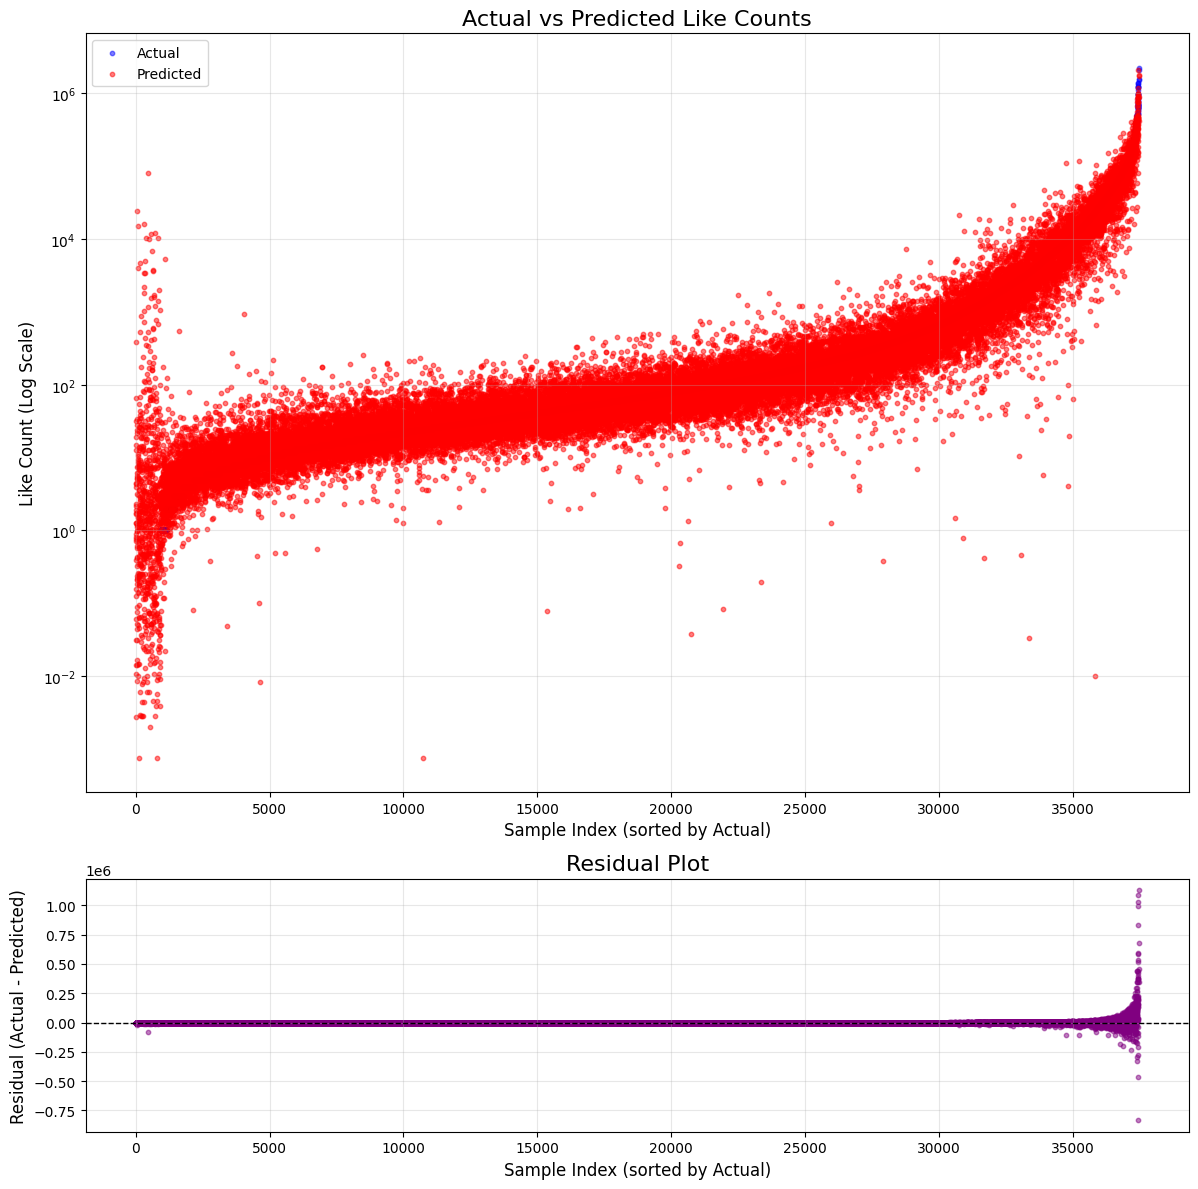

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Convert predictions and actual values into a DataFrame for visualization
results_df = pd.DataFrame({
    'Actual': y_val,
    'Predicted': y_pred
})

# Sort by the actual values
results_df = results_df.sort_values(by='Actual').reset_index(drop=True)

# Add residuals
results_df['Residual'] = results_df['Actual'] - results_df['Predicted']

# Create a multi-panel figure
fig, ax = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [3, 1]})

# --- Top Panel: Actual vs Predicted ---
ax[0].scatter(
    range(len(results_df)), results_df['Actual'], label='Actual', alpha=0.5, color='blue', s=10
)
ax[0].scatter(
    range(len(results_df)), results_df['Predicted'], label='Predicted', alpha=0.5, color='red', s=10
)
ax[0].set_title("Actual vs Predicted Like Counts", fontsize=16)
ax[0].set_xlabel("Sample Index (sorted by Actual)", fontsize=12)
ax[0].set_ylabel("Like Count (Log Scale)", fontsize=12)
ax[0].set_yscale('log')
ax[0].legend()
ax[0].grid(alpha=0.3)

# --- Bottom Panel: Residual Plot ---
ax[1].scatter(
    range(len(results_df)), results_df['Residual'], alpha=0.5, color='purple', s=10
)
ax[1].axhline(0, color='black', linestyle='--', linewidth=1)
ax[1].set_title("Residual Plot", fontsize=16)
ax[1].set_xlabel("Sample Index (sorted by Actual)", fontsize=12)
ax[1].set_ylabel("Residual (Actual - Predicted)", fontsize=12)
ax[1].grid(alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()


In [41]:
path = "test-regression-round2.jsonl"


# Step 1: Initialize an empty list for the test data
data = []
# Step 2: Load the test set
with open(path, "rt") as fh:
    for line in fh:
        # Parse the JSON line
        sample = json.loads(line)
        
        user = sample.get("username")
        user_profile = profiles[user] #reaching user profiles which are present in the dataset. 

        
        
        # Extract user-specific features and initialize missing features
        data.append({
            "username": sample.get("username"),  # This will help us map users between test and train
            "timestamp": sample.get("timestamp"),
            "follower_count": user_profile.get("follower_count", 0),
            "following_count": user_profile.get("following_count", 0),
            "highlight_reel_count": user_profile.get("highlight_reel_count", 0),
            "is_verified": user_profile.get("is_verified", False),
            "is_business_account": user_profile.get("is_business_account", False),
            "is_private": user_profile.get("is_private", False),
            "category_name": user_profile.get("category_name", None),
            "media_type": sample.get("media_type", None),
            "comments_count": sample.get("comments_count", 0),
            "id": sample.get("id", ""),
            # Initialize missing features that will be calculated later
            "average_like": None,
            "engagement_rate": None,
        })


# Convert the test data into a DataFrame
df_test = pd.DataFrame(data)

df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])  # Ensure it's a datetime object
# Extract features from timestamp
df_test['hour'] = df_test['timestamp'].dt.hour
df_test['day_of_week'] = df_test['timestamp'].dt.dayofweek
df_test['day_of_year'] = df_test['timestamp'].dt.dayofyear
df_test['month'] = df_test['timestamp'].dt.month
# Example: Bin hours into time of day
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']
df_test['time_of_day'] = pd.cut(df_test['hour'], bins=bins, labels=labels, right=False)
# Convert categorical 'time_of_day' to numerical using one-hot encoding if needed
df_test = pd.get_dummies(df_test, columns=['time_of_day'])

df_test = df_test.drop(columns=['hour', 'month', 'timestamp'])

# Convert Boolean columns to numerical (1/0)
df_test[['time_of_day_Night', 'time_of_day_Morning', 'time_of_day_Afternoon', 'time_of_day_Evening']] = \
    df_test[['time_of_day_Night', 'time_of_day_Morning', 'time_of_day_Afternoon', 'time_of_day_Evening']].astype(int)

#label encoder
df_test["category_name"] = label_encoder.fit_transform(df_test['category_name'])
df_test["media_type"] = label_encoder.fit_transform(df_test['media_type'])

# Convert binary columns (True/False) to 0/1
binary_columns = ['is_verified', 'is_private', 'is_business_account']
for col in binary_columns:
    df_test[col] = df_test[col].astype(int)



# Step 3: Calculate average_like for each user in the test set based on the training set
# Training set is labeled as `df` in your code
# Ensure the training set has the 'username' and 'like_count' columns
user_average_likes = df_train.groupby("username")["like_count"].mean()

# Map average_like from the training set to the test set
df_test["average_like"] = df_test["username"].map(user_average_likes)

# Step 4: Handle missing values for users not present in the training set
df_test["average_like"]=df_test["average_like"].fillna(0)  # Replace NaN with 0 or an appropriate default value

# Step 5: Calculate other derived features if necessary

df_test["engagement_rate"] = df_test["average_like"] / (df_test["follower_count"] + 1e-9)

# Step 6: Prepare df_test for prediction
# Ensure the feature columns in df_test match those used during model training
# Drop unnecessary columns or encode them if required
columns_to_drop = ["username", "id"]  # Drop non-numerical or irrelevant columns
df_test_prepared = df_test.drop(columns=columns_to_drop)

# Define the custom order of columns
custom_order = [
    'follower_count', 
    'following_count', 
    'highlight_reel_count', 
    'is_verified', 
    'is_business_account', 
    'is_private', 
    'category_name', 
    'average_like', 
    'media_type', 
    'comments_count', 
    'day_of_week', 
    'day_of_year', 
    'time_of_day_Night', 
    'time_of_day_Morning', 
    'time_of_day_Afternoon', 
    'time_of_day_Evening'
]
df_test_prepared = df_test_prepared[custom_order]

print(df_test_prepared.isnull().sum())
df_test_prepared.head()

follower_count           0
following_count          0
highlight_reel_count     0
is_verified              0
is_business_account      0
is_private               0
category_name            0
average_like             0
media_type               0
comments_count           0
day_of_week              0
day_of_year              0
time_of_day_Night        0
time_of_day_Morning      0
time_of_day_Afternoon    0
time_of_day_Evening      0
dtype: int64


,follower_count,following_count,highlight_reel_count,is_verified,is_business_account,is_private,category_name,average_like,media_type,comments_count,day_of_week,day_of_year,time_of_day_Night,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening
0,10676,744,4,1,1,0,269,1105.828571,1,3,1,33,0,0,1,0
1,58038,94,69,1,0,0,269,1864.200000,2,63,3,327,0,0,1,0
2,72118,417,20,0,0,0,238,2044.285714,2,27,2,88,0,0,0,1
3,153063,1029,0,1,0,0,17,22095.971429,0,125,2,109,0,0,1,0
4,512923,733,19,1,0,0,243,13622.057143,0,108,4,265,0,1,0,0


In [42]:
# Step 7: Predict like counts
# Make predictions with your trained model (e.g., RandomForestRegressor, StackingRegressor, etc.)
predictions_log = model.predict(df_test_prepared)

# Step 8: Inverse transform predictions if necessary
# If your model predicted log-transformed like counts, reverse the transformation
predictions = np.expm1(predictions_log)  # Transform back to original scale


# Step 9: Add predictions to df_test
df_test["predicted_like_count"] = predictions


# Prepare the output dictionary
output_predictions = {}

# Iterate over the test set to fill the output dictionary
for _, row in df_test.iterrows():
    post_id = row["id"]  # Replace with the actual column name for the unique ID
    predicted_like_count = row["predicted_like_count"]
    output_predictions[post_id] = int(predicted_like_count)  # Ensure prediction is saved as an integer

# Write the output to a JSON file
output_path = "prediction-regression-round2.json"
with open(output_path, "w") as output_file:
    json.dump(output_predictions, output_file, indent=4)

print(f"Predictions saved to {output_path}")

Predictions saved to prediction-regression-round2.json
